In this notebook, I will be using SLiM to simulate background selection. I will simulate under a variety of strengths of BGS, and see what effect this has on $r^2$ between mutations, and on my tree probabilities (as estimated with my algorithm). I also want to survey the mean and variance of coalesence times, and the proportion of external branches as I have been doing until now. 

In [1]:
import os, subprocess, msprime, statistics, pyslim
import matplotlib.pyplot as plt
import numpy as np
import tskit
from msp_sim import *
from tree_LD_analysis import *
import os
import pandas as pd
import seaborn as sns

Some preliminary questions about the simulation: 
* What range of strengths of BGS are appropriate?
    + I've been drawing fitness effects from a gamma distribution with rate -(x/N) (so I scale with population size) and rate 1. This scaling leads to a more direct intergpretation relationship with 2Ns. I've also been simulating dominance coefficients of 0.5 - I guess this is not totally appropriate.
    This was inspired by Haller, BC, Galloway, J, Kelleher, J, Messer, PW, Ralph, PL. Tree-sequence recording in SLiM opens new horizons for forward-time simulation of whole genomes. Mol Ecol Resour. 2019; 19: 552– 566. https://doi.org/10.1111/1755-0998.12968
    + In my previous msprime simulations, propulations have been 20,000 individuals. This is a little large for SLiM simulation - at least for playground simulations. Some options are:
        + Simulate smaller populations.
        + Simulate large populations, sample an un-coalesced tree and the recapitate it. This has the advantage of being quick and easy, but the disadvantage that balancing selection will only affect the 'bottom' un-recapitated part of the tree. So I'd still need to run the simulation long enough that a large proportion of the tree is un-recapitated. Even if I wait for all but the last two individuals to coalesce, the tree above is expected to be half the total tree length - so we would still only affect half of the observed genealogy with BGS.
        + Just run chunky simulations...
Right now, I'm simulating a small population of 1000 individuals. I'm also adding a long burn-in.

How will I get the features I want?
- $r^2$ between mutations
    + I'm having an issue with the encoding of the derived allele from SLiM simulations, so I'll get this with the tskit LD calculator - for now...
- Configuration probabilities (as estimated with my algorithm)
    + This is in the function `get_configuration_probabilities(tree)` 
- The mean and variance of coalesence times
    + This is in the function `get_mn_tmrca(ts,pop_size)` 
- The proportion of internal branches
    + This is in the function `internal_branch_length(ts)`


Potentially things to add:
- total tree height?
    
In order to run the simulations, I can run the script `run_BGS_sims.txt`. 

In [2]:
# value for n
n=1_000

# base directory to store results of simulation
output_dir="SLiM_output/BGS/2023-02-10/n_"

# gather all subdirectories in the base directory that do not start with "." (hidden directories)
d_dirs=[direc for direc in os.listdir(output_dir+str(n)) if not direc.startswith('.')]

# convert the names of subdirectories to float values of d
ds=[float(dr[2:]) for dr in d_dirs]

# dictionary to store tree sequences for each value of d
tree_seqs={}

# loop through all subdirectories and gather the tree sequences
for i in range(len(d_dirs)):
    d=ds[i]
    # create a list for each value of d to store the tree sequences
    tree_seqs[str(d)]=[]
    # list of tree sequence files for the current value of d
    tree_files = [output_dir+str(n)+"/"+d_dirs[i]+"/"+filename for
                  filename in os.listdir(output_dir+str(n)+"/"+d_dirs[i])]
    # loop through all tree sequence files and simplify them
    for tree_file in tree_files:
        # load the tree sequence and simplify it by keeping only the first 200 samples
        ts=tskit.load(tree_file).simplify(samples=range(0,200))
        # add the tree sequence to the list of tree sequences for the current value of d
        tree_seqs[str(d)].append(ts)

In [3]:
# Initialize an empty dictionary to store results
results = {}

# Loop through the keys and index of the dictionary "tree_seqs"
for i, param_key in enumerate(tree_seqs):
    # Extract the current parameter value
    current_param = ds[i]
    # Initialize an empty dictionary to store results for the current parameter
    current_param_results = {}

    # Extract the list of tree sequences for the current parameter
    tree_seq_list = tree_seqs[param_key]
    # Check if there are any tree sequences for the current parameter
    if len(tree_seq_list) > 0:
        # Initialize empty arrays to store the results for the current parameter
        config_probs = np.empty((1,3))
        coalescence_times = np.empty((1,3))
        internal_branch_lengths = []

        # Loop through the replicates for the current parameter
        for replicate in range(len(tree_seq_list)):
            # Extract the current tree sequence
            curr_tree_seq = tree_seq_list[replicate]
            # Get the first tree in the sequence
            first_tree = curr_tree_seq.first()
            # Calculate the configuration probabilities for the first tree
            configuration_probs = get_configuration_probabilities(first_tree)
            # Calculate the mean coalescence time for the first tree
            mean_coalescence_time = get_mn_tmrca(first_tree, pop_size=1_000)
            # Calculate the internal branch length for the current tree sequence
            internal_branch_len = internal_branch_length(curr_tree_seq)
            # Stack the results to the arrays for the current parameter
            coalescence_times = np.vstack((coalescence_times, mean_coalescence_time))
            config_probs = np.vstack((config_probs, configuration_probs))
            internal_branch_lengths.append(internal_branch_len)   

        # Add the results for the current parameter to the inner dictionary
        current_param_results["config_probs"] = config_probs
        current_param_results["coalescence_times"] = coalescence_times
        current_param_results["internal_branch_lengths"] = internal_branch_lengths
        # Add the inner dictionary to the results dictionary with the current parameter as the key
        results[param_key] = current_param_results

Text(0.5, 0.98, 'Background Selection')

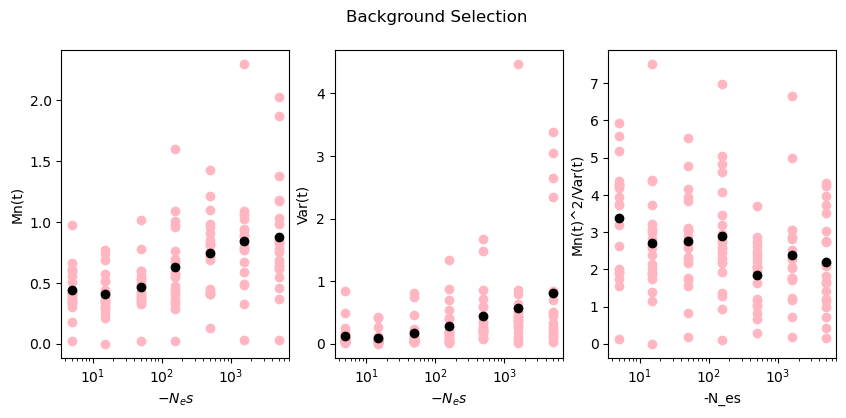

In [4]:
fig,ax=plt.subplots(1,3,figsize=(10,4),sharey=False)


for d in ds:
    for i in range(3):
        try:
            ax[i].scatter([d]*len(results[str(d)]["coalescence_times"][:,i]),
                          results[str(d)]["coalescence_times"][:,i],c="lightpink")
            ax[i].scatter([d],
                          np.nanmean(results[str(d)]["coalescence_times"][:,i]),c="black")
            ax[i].set_xlabel("$-N_es$")
        except:
            pass
ax[0].set_xscale("log");
ax[1].set_xscale("log");
ax[2].set_xscale("log");
ax[0].set_ylabel("Mn(t)")
ax[1].set_ylabel("Var(t)")
ax[2].set_ylabel("Mn(t)^2/Var(t)")
plt.xlabel("-N_es")
fig.suptitle("Background Selection")

Text(0.5, 0.98, 'Background Selection')

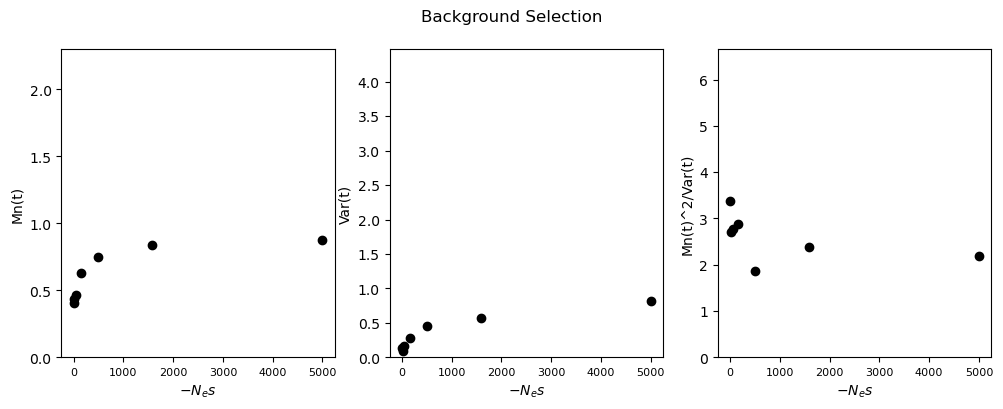

In [5]:
import seaborn as sns
import pandas as pd

# Initialize the figure with 1 row and 3 columns of subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Define the labels for each subplot
labels = ["Mn(t)", "Var(t)", "Mn(t)^2/Var(t)"]

# Iterate over each subplot
for i in range(3):
    # Create a DataFrame with the data for the current subplot
    data = pd.DataFrame()
    for d in ds:
        data[str(d)] = results[str(d)]["coalescence_times"][:, i]
    # Plot the box plot for the current subplot using seaborn
    #sns.boxplot(data=data, ax=ax[i], color="lightpink")
    # Plot the mean of the data for each value of d
    for d in ds:
        ax[i].scatter([d], np.nanmean(results[str(d)]["coalescence_times"][:, i]), c="black")
    # Set the y-axis label for the current subplot
    ax[i].set_ylabel(labels[i])
    # Set the y-axis limits to (0, max(coalescence_times))
    ax[i].set_ylim((0, np.nanmax(results[str(d)]["coalescence_times"][:, i])))
    # Set the x-axis scale to logarithmic
    #ax[i].set_xscale("log")
    # Set the x-axis label for the current subplot
    ax[i].set_xlabel("$-N_es$")
    # Set the x-axis tick labels to a smaller font size
    ax[i].tick_params(axis="x", labelsize=8)

# Set the overall title for the figure
fig.suptitle("Background Selection")


Text(0.5, 0, '-N_es')

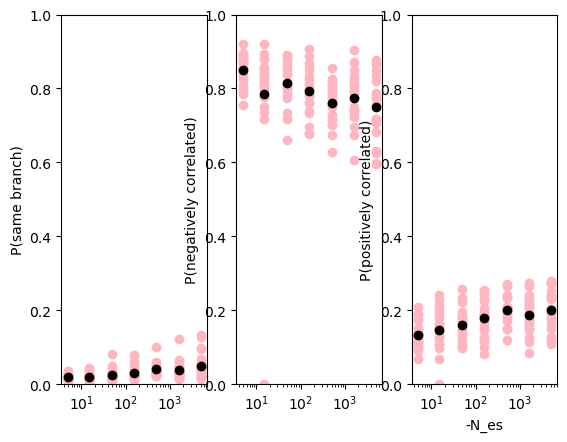

In [6]:
# Initialize the figure with 1 row and 3 columns of subplots
fig, ax = plt.subplots(1, 3)

# Iterate over each subplot
for i in range(3):
    # Iterate over each value of d
    for d in ds:
        # Plot the scatter plot for each value of "config_probs"
        ax[i].scatter([d] * len(results[str(d)]["config_probs"][:, i]), 
                      results[str(d)]["config_probs"][:, i], c="lightpink")
        
        # Plot the mean of "config_probs" for each value of d
        ax[i].scatter([d], np.nanmean(results[str(d)]["config_probs"][:, i]), c="black")
        
        # Set the y-axis limits to (0,1)
        ax[i].set_ylim((0, 1))

# Set the x-axis scale to logarithmic for all subplots
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")

# Set the y-axis label for the first subplot
ax[0].set_ylabel("P(same branch)")

# Set the y-axis label for the second subplot
ax[1].set_ylabel("P(negatively correlated)")

# Set the y-axis label for the third subplot
ax[2].set_ylabel("P(positively correlated)")

# Set the x-axis label for all subplots
plt.xlabel("-N_es")

/var/folders/2c/shhlynq131n5tph175rgr4fm0000gn/T/ipykernel_24900/611095482.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_d)
/var/folders/2c/shhlynq131n5tph175rgr4fm0000gn/T/ipykernel_24900/611095482.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_d)
/var/folders/2c/shhlynq131n5tph175rgr4fm0000gn/T/ipykernel_24900/611095482.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_d)
/var/folders/2c/shhlynq131n5tph175rgr4fm0000gn/T/ipykernel_24900/611095482.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_d)
/var/folders/2c/shhlynq131n5tph175rgr4fm0000gn/T

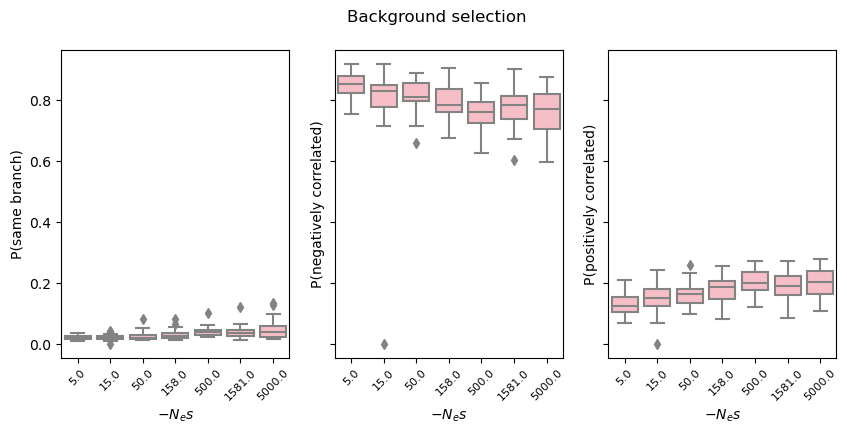

In [7]:
import pandas as pd
import seaborn as sns

# Initialize the figure with 1 row and 3 columns of subplots
fig, ax = plt.subplots(1, 3, sharey=True,figsize=(10,4))

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate over each value of d
for d in ds:
    # Create a DataFrame for the current value of d
    df_d = pd.DataFrame(results[str(d)]["config_probs"], columns=["Same Branch", "Neg. Corr.", "Pos. Corr."])
    
    # Add a column to the DataFrame for the value of d
    df_d["d"] = d
    
    # Append the DataFrame to the main DataFrame
    df = df.append(df_d)
    
# Iterate over each subplot
for i in range(3):
    # Plot the box plot for the current value of "config_probs"
    sns.boxplot(x="d", y=df.columns[i], data=df, ax=ax[i], color="lightpink")
    
   # Set the x-axis scale to logarithmic for the current subplot
    #ax[i].set_xscale("log")
    
    # Set the x-axis label for the current subplot
    ax[i].set_xlabel("$-N_es$")
    # Set the x-axis tick labels to a smaller font size
    ax[i].tick_params(axis='x', labelsize=8,rotation=45)
    
# Set the y-axis label for the first subplot
ax[0].set_ylabel("P(same branch)")

# Set the y-axis label for the second subplot
ax[1].set_ylabel("P(negatively correlated)")

# Set the y-axis label for the third subplot
ax[2].set_ylabel("P(positively correlated)")

fig.suptitle("Background selection")
plt.savefig("BGS_configurations.pdf")

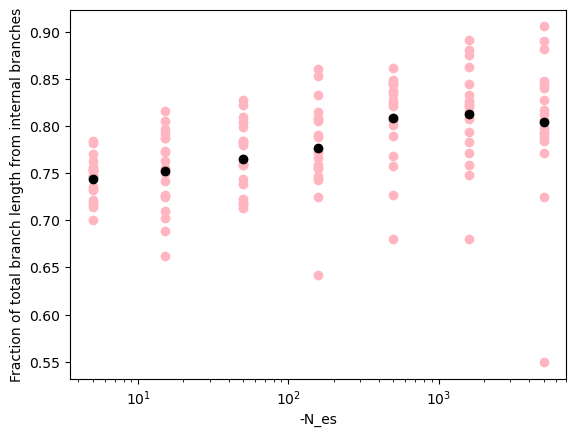

In [8]:
for d in ds:
    try:
        plt.scatter([d]*len(results[str(d)]["internal_branch_lengths"]),
                    results[str(d)]["internal_branch_lengths"],c="lightpink")
        plt.scatter([d],
                    np.nanmean(results[str(d)]["internal_branch_lengths"]),c="black")
    except:
        pass
plt.xscale("log");
plt.ylabel("Fraction of total branch length from internal branches")
plt.xlabel("-N_es");

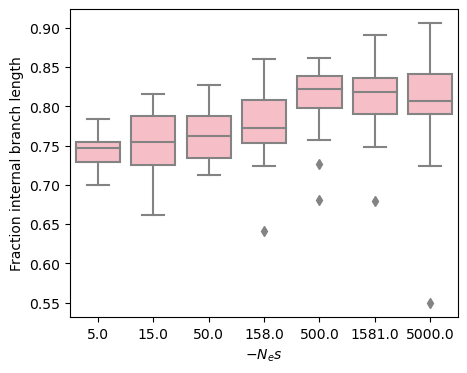

In [27]:
plt.figure(figsize=(5,4))
# Convert the results dictionary into a pandas DataFrame
df = pd.DataFrame.from_dict(results, orient='index')
df.index.name = 'd'
df.reset_index(inplace=True)

# Explode the "internal_branch_lengths" column
df = df.explode("internal_branch_lengths")

# Convert the "internal_branch_lengths" column to numeric
df["internal_branch_lengths"] = pd.to_numeric(df["internal_branch_lengths"])
df["d"] = pd.to_numeric(df["d"])

# Plot the box plot using seaborn
sns.boxplot(x='d', y='internal_branch_lengths', data=df, color='lightpink')
#sns.stripplot(x='d', y='internal_branch_lengths', data=df, color='black')

# Set plot labels and axis scale

plt.ylabel("Fraction internal branch length")
plt.xlabel("$-N_es$")
plt.savefig("BGS_ibl.pdf")

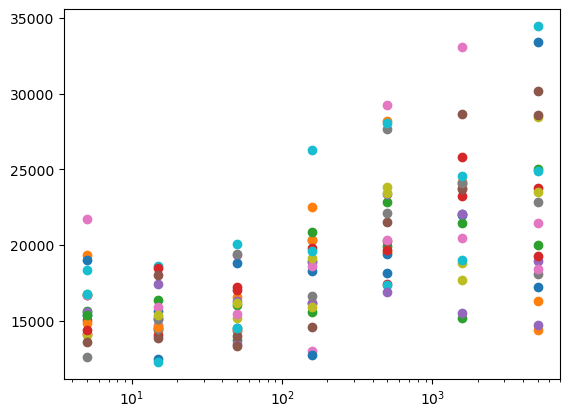

In [12]:
for d in ds:
    num_trees=len(tree_seqs[str(d)])
    branch_lengths=[]
    for i in range(num_trees):
        ts=tree_seqs[str(d)][i]
        tree=ts.first()
        plt.scatter(d,tree.total_branch_length)
plt.xscale("log")

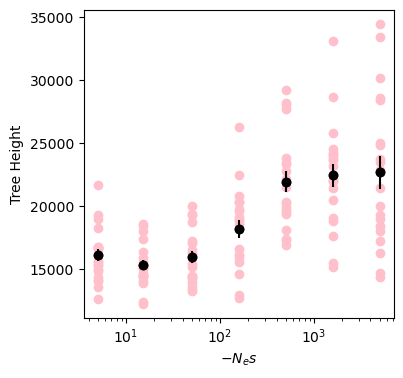

In [28]:
plt.figure(figsize=(4,4))
for d in ds:
    num_trees=len(tree_seqs[str(d)])
    heights=[]
    for i in range(num_trees):
        ts=tree_seqs[str(d)][i]
        tree=ts.first()
        heights.append(tree.total_branch_length)
        plt.scatter(d, tree.total_branch_length, c="pink")
    mean_height = np.mean(heights)
    std_error = np.std(heights) / np.sqrt(num_trees)
    plt.scatter(d, mean_height, c=d)
    plt.errorbar(d, mean_height, yerr=std_error, fmt='o', c="black")

plt.xscale("log")
plt.xlabel("$-N_es$")
plt.ylabel("Tree Height")
plt.savefig("BGS_treeheight.pdf")

Text(0.5, 0, '-Nes')

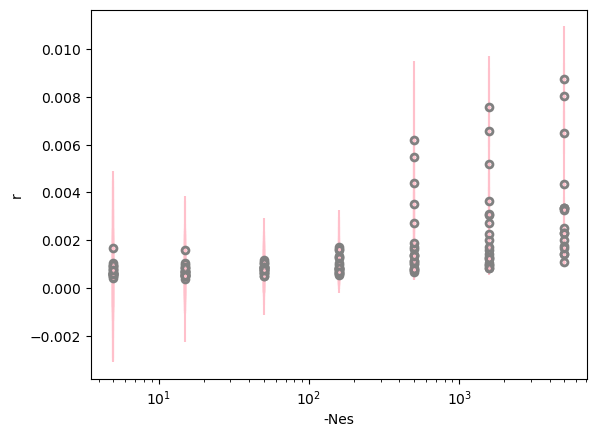

In [16]:
for d in ds:
    for ts in tree_seqs[str(d)]:
        try:
            rmat=np.cov(np.vstack([m for m in list(ts.genotype_matrix())]))
            rmat=np.tril(rmat)
            rmat[rmat==0]=np.nan
            plt.errorbar(d,np.nanmean(rmat),np.sqrt(np.nanvar(rmat))*0.1, marker="o",
             mec='grey', ms=2, mew=5,c="pink")
        except:
            pass
plt.xscale("log")
plt.ylabel("r")
plt.xlabel("-Nes")

Text(0.5, 0, '-Nes')

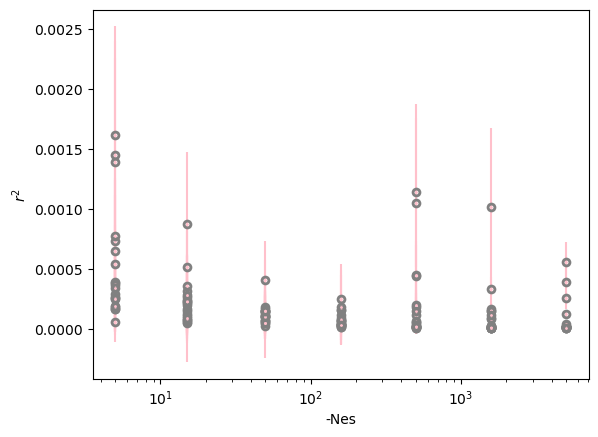

In [22]:
for d in ds:
    for ts in tree_seqs[str(d)]:
        try:
            rmat=np.square(np.cov(np.vstack([m for m in list(ts.genotype_matrix())])))
            rmat=np.tril(rmat,k=0)
            rmat[rmat==0]= np.nan
            plt.errorbar(d,np.nanmean(rmat),np.sqrt(np.nanvar(rmat))*0.1, marker="o",
             mec='grey', ms=2, mew=5,c="pink")
        except:
            pass
plt.xscale("log")
plt.ylabel("$r^2$")
plt.xlabel("-Nes")

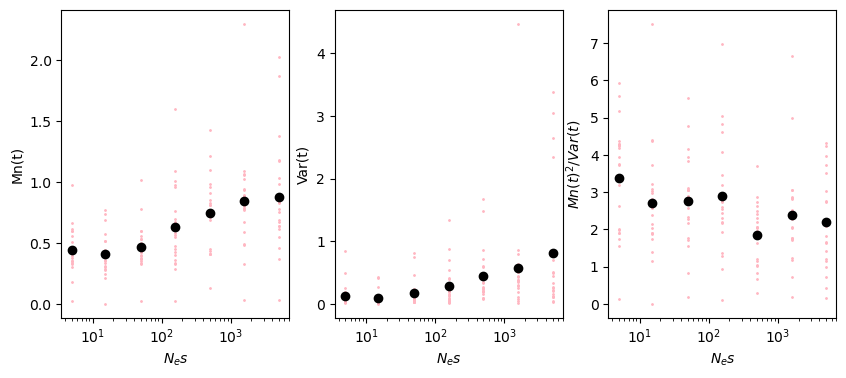

In [25]:
fig,ax=plt.subplots(1,3,figsize=(10,4),sharey=False)

for d in ds:
    for i in range(3):
        try:
            ax[i].scatter([d]*len(results[str(d)]["coalescence_times"][:,i]),
                          results[str(d)]["coalescence_times"][:,i],c="lightpink",s=1)
            ax[i].scatter([d],
                          np.nanmean(results[str(d)]["coalescence_times"][:,i]),c="black")
            ax[i].set_xlabel("$N_es$")
        except:
            pass
ax[0].set_xscale("log");
ax[1].set_xscale("log");
ax[2].set_xscale("log");
ax[0].set_ylabel("Mn(t)")
ax[1].set_ylabel("Var(t)")
ax[2].set_ylabel("$Mn(t)^2/Var(t)$")

plt.savefig("bgs_mnvar.pdf")

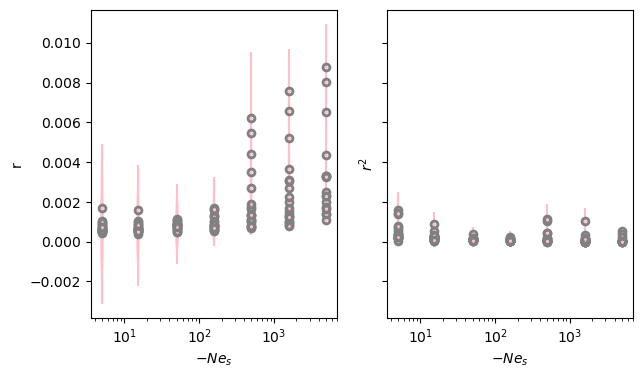

In [24]:
fig, ax = plt.subplots(1, 2,figsize=(7,4),sharey=True)

for d in ds:
    for ts in tree_seqs[str(d)]:
        try:
            rmat=np.cov(np.vstack([m for m in list(ts.genotype_matrix())]))
            rmat=np.tril(rmat)
            rmat[rmat==0]=np.nan
            ax[0].errorbar(d,np.nanmean(rmat),np.sqrt(np.nanvar(rmat))*0.1, marker="o",
             mec='grey', ms=2, mew=5,c="pink")
        except:
            pass
ax[0].set_xscale("log")
ax[0].set_ylabel("r")
ax[0].set_xlabel("$-Ne_s$")

for d in ds:
    for ts in tree_seqs[str(d)]:
        try:
            rmat=np.cov(np.vstack([m for m in list(ts.genotype_matrix())]))
            rmat=np.tril(rmat)**2
            rmat[rmat==0]=np.nan
            ax[1].errorbar(d,np.nanmean(rmat),np.sqrt(np.nanvar(rmat))*0.1, marker="o",
             mec='grey', ms=2, mew=5,c="pink")
        except:
            pass

ax[1].set_xscale("log")
ax[1].set_ylabel("$r^2$")
ax[1].set_xlabel("$-Ne_s$")
plt.savefig("bgs_r.pdf")